<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>

<h1 align="center"><font size="5">Unsupervised Machine Learning - Final Assignment</font></h1>


# Introduction

The aim of this workbook is to use unsupervised learning to draw insights from a dataset.

# Lib Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.cluster import KMeans, DBSCAN, MeanShift

# Dataset Info

__name:__ Bank Customer Segmentation (1M+ Transactions)\
__source:__ Kaggle\
__url:__ https://www.kaggle.com/datasets/shivamb/bank-customer-segmentation

Bank Customer Segmentation
Most banks have a large customer base - with different characteristics in terms of age, income, values, lifestyle, and more. Customer segmentation is the process of dividing a customer dataset into specific groups based on shared traits.

According to a report from Ernst & Young, “A more granular understanding of consumers is no longer a nice-to-have item, but a strategic and competitive imperative for banking providers. Customer understanding should be a living, breathing part of everyday business, with insights underpinning the full range of banking operations.

About this Dataset
This dataset consists of 1 Million+ transaction by over 800K customers for a bank in India. The data contains information such as - customer age (DOB), location, gender, account balance at the time of the transaction, transaction details, transaction amount, etc.

https://www.kaggle.com/code/yuvraj5857/exploring-bank-transaction-dataset-using-pyspark#2.-Data-Transformation-and-Cleaning

## 1. EDA

### 1.1 Dataset Loading

In [3]:
df = pd.read_csv('bank_transactions.csv')
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


First step is to check for missing or null values.

In [4]:
(df.isna().sum() / len(df)) * 100

TransactionID              0.000000
CustomerID                 0.000000
CustomerDOB                0.323966
CustGender                 0.104905
CustLocation               0.014401
CustAccountBalance         0.225927
TransactionDate            0.000000
TransactionTime            0.000000
TransactionAmount (INR)    0.000000
dtype: float64

There do seem to be missing entries but they are all below 1%, so I think I will drop them from the dataset.

In [5]:
df.dropna(inplace=True)

In [6]:
df.isna().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

Now I will review the datatypes of the columns.

In [7]:
df.dtypes

TransactionID               object
CustomerID                  object
CustomerDOB                 object
CustGender                  object
CustLocation                object
CustAccountBalance         float64
TransactionDate             object
TransactionTime              int64
TransactionAmount (INR)    float64
dtype: object

Initial insight is that there seem to be some columns which are currently represented as objects, but can be represented numerically either via encoding or as time / date, which will be done during the Feature Engineering step.

I will quickly review the distribution of the TransactionID and CustomerID columns.

In [8]:
transaction_id_vc = df['TransactionID'].value_counts()
transaction_id_vc

TransactionID
T1          1
T699342     1
T699328     1
T699329     1
T699330     1
           ..
T349709     1
T349710     1
T349711     1
T349712     1
T1048567    1
Name: count, Length: 1041614, dtype: int64

In [9]:
transaction_id_vc[transaction_id_vc > 1]

Series([], Name: count, dtype: int64)

So the TransactionID appears to be unique to each entry, so this can probably be removed.

In [10]:
customer_id_vc = df['CustomerID'].value_counts()
customer_id_vc

CustomerID
C5533885    6
C7537344    6
C1736254    6
C1113684    6
C4327447    6
           ..
C1610768    1
C4929259    1
C1026114    1
C6817889    1
C6420483    1
Name: count, Length: 879358, dtype: int64

In [11]:
customer_id_vc[customer_id_vc > 1]

CustomerID
C5533885    6
C7537344    6
C1736254    6
C1113684    6
C4327447    6
           ..
C2239666    2
C5811913    2
C1635174    2
C6229976    2
C6442630    2
Name: count, Length: 141961, dtype: int64

The CustomerID has some instances where there are more than one value, so this can stay in the dataset.

### 1.2 Data Preprocessing

Tasks in this step include:

1. Removing unnecessary columns
2. Encoding or converting object classes
3. Normalizing numerical classes

In [12]:
df.drop('TransactionID', axis=1, inplace=True)

The next step is to convert the object columns which are dates to actual date values.

In [13]:
df.head()

,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [14]:
DATE_COLUMNS = ['CustomerDOB', 'TransactionDate']

In [15]:
df[DATE_COLUMNS] = df[DATE_COLUMNS].astype('datetime64[ns]')
df[DATE_COLUMNS].head()

,CustomerDOB,TransactionDate
0,1994-10-01,2016-02-08
1,2057-04-04,2016-02-08
2,1996-11-26,2016-02-08
3,2073-09-14,2016-02-08
4,1988-03-24,2016-02-08


__Acceptable Date Ranges__

Finally need to check to make sure there are no abnormal dates.

In [152]:
df['CustomerDOB'].max()

Timestamp('2073-12-31 00:00:00')

In [148]:
df['CustomerDOB'].min()

Timestamp('1800-01-01 00:00:00')

In [149]:
acceptable_customer_dob = (df['CustomerDOB'] > '1800-01-01 00:00:00') & (df['CustomerDOB'] < '2073-12-31 00:00:00')
df[acceptable_customer_dob]

In [151]:
df['TransactionDate'].min()

Timestamp('2016-01-08 00:00:00')

Next step is to convert Gender from an object to labels.

In [16]:
df['CustGender'] = df['CustGender'].apply(lambda x: 0 if x == 'M' else 1)
df['CustGender'].unique()

array([1, 0])

In [17]:
unique_locations = df['CustLocation'].unique()
print(f"num unique locations: {len(unique_locations)}")
unique_locations

num unique locations: 9275


array(['JAMSHEDPUR', 'JHAJJAR', 'MUMBAI', ..., 'KARANJIA',
       'NR HERITAGE FRESH HYDERABAD', 'IMPERIA THANE WEST'], dtype=object)

There are two many locations to use categorical encoding, as this will introduce too many features into the dataset. I've noticed that there are some locations that have brackets in the name, so maybe these can be excluded.

In [18]:
bracketed_locations = [loc for loc in unique_locations if loc.find('(') != -1]
print(f"num bracketed locations {len(bracketed_locations)}")

num bracketed locations 365


These aren't much help. Ill do a value counts to see how many non unique values there are.

In [27]:
loc_value_counts = df['CustLocation'].value_counts() / len(df) * 100
loc_value_counts

CustLocation
MUMBAI                            9.792207
NEW DELHI                         8.078136
BANGALORE                         7.808075
GURGAON                           7.065381
DELHI                             6.773046
                                    ...   
DISTRICT PURI                     0.000096
DHAKOLA                           0.000096
KANDESHWAR STATION NAVI MUMBAI    0.000096
HOSHIAR PUR                       0.000096
IMPERIA THANE WEST                0.000096
Name: count, Length: 9275, dtype: float64

Reviewing this, I think it may be worth removing anything with less than 0.125% of the entries in the dataset, otherwise categorization is too difficult.

In [66]:
locations_percentage_threshold = loc_value_counts[loc_value_counts >= 0.125]

In [67]:
allowed_locations = locations_percentage_threshold.index.to_list()
allowed_locations

['MUMBAI',
 'NEW DELHI',
 'BANGALORE',
 'GURGAON',
 'DELHI',
 'NOIDA',
 'CHENNAI',
 'PUNE',
 'HYDERABAD',
 'THANE',
 'KOLKATA',
 'GHAZIABAD',
 'NAVI MUMBAI',
 'AHMEDABAD',
 'FARIDABAD',
 'JAIPUR',
 'CHANDIGARH',
 'LUCKNOW',
 'MOHALI',
 'SURAT',
 'NASHIK',
 'LUDHIANA',
 'VISAKHAPATNAM',
 'DEHRADUN',
 'INDORE',
 'AMRITSAR',
 'VADODARA',
 'AGRA',
 'NAGPUR',
 'COIMBATORE',
 'KANPUR',
 'MEERUT',
 'PANCHKULA',
 'AURANGABAD',
 'GREATER NOIDA',
 'GUWAHATI',
 'GUNTUR',
 'JALANDHAR',
 'RANGA REDDY',
 'BHOPAL',
 'UDAIPUR',
 'PATNA',
 'RANCHI',
 'ERNAKULAM',
 'REWARI',
 'BENGALURU',
 'PATIALA',
 'SECUNDERABAD',
 'HOWRAH',
 'PANIPAT',
 'ALWAR',
 'ALLAHABAD',
 'SONIPAT',
 'NORTH 24 PARGANAS',
 'ZIRAKPUR',
 'RAJKOT',
 'RAIPUR',
 'BAMBOLIM',
 'KOLHAPUR',
 'SILIGURI',
 'MANGALORE',
 'JAMSHEDPUR',
 'BAREILLY',
 'ALIGARH',
 'KARNAL',
 'HOSUR',
 'KANGRA',
 'SAHARANPUR',
 'WARANGAL',
 'JODHPUR',
 'MORADABAD',
 'KHARAR',
 'KOTTAYAM',
 'AMBALA']

Removing unnecessary Locations and birthdays.

In [140]:
allowed_location_mask = (df['CustLocation'].isin(allowed_locations))

In [141]:
final_df = df[allowed_location_mask]

In [142]:
print(f"percentage change in: {((len(df) - len(final_df)) / len(df)) * 100}")

percentage change in: 24.323309786542808


Losing about 24% of observations which isn't ideal but it will do for now.

In [130]:
location_dummies = pd.get_dummies(final_df['CustLocation']).astype(int)
location_dummies

,AGRA,AHMEDABAD,ALIGARH,ALLAHABAD,ALWAR,AMBALA,AMRITSAR,AURANGABAD,BAMBOLIM,BANGALORE,...,SECUNDERABAD,SILIGURI,SONIPAT,SURAT,THANE,UDAIPUR,VADODARA,VISAKHAPATNAM,WARANGAL,ZIRAKPUR
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048562,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1048563,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1048564,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1048565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [139]:
final_df.loc[location_dummies.columns] = location_dummies.values
final_df.drop('CustLocation', axis=1, inplace=True)

KeyError: "None of [Index(['AGRA', 'AHMEDABAD', 'ALIGARH', 'ALLAHABAD', 'ALWAR', 'AMBALA',\n       'AMRITSAR', 'AURANGABAD', 'BAMBOLIM', 'BANGALORE', 'BAREILLY',\n       'BENGALURU', 'BHOPAL', 'CHANDIGARH', 'CHENNAI', 'COIMBATORE',\n       'DEHRADUN', 'DELHI', 'ERNAKULAM', 'FARIDABAD', 'GHAZIABAD',\n       'GREATER NOIDA', 'GUNTUR', 'GURGAON', 'GUWAHATI', 'HOSUR', 'HOWRAH',\n       'HYDERABAD', 'INDORE', 'JAIPUR', 'JALANDHAR', 'JAMSHEDPUR', 'JODHPUR',\n       'KANGRA', 'KANPUR', 'KARNAL', 'KHARAR', 'KOLHAPUR', 'KOLKATA',\n       'KOTTAYAM', 'LUCKNOW', 'LUDHIANA', 'MANGALORE', 'MEERUT', 'MOHALI',\n       'MORADABAD', 'MUMBAI', 'NAGPUR', 'NASHIK', 'NAVI MUMBAI', 'NEW DELHI',\n       'NOIDA', 'NORTH 24 PARGANAS', 'PANCHKULA', 'PANIPAT', 'PATIALA',\n       'PATNA', 'PUNE', 'RAIPUR', 'RAJKOT', 'RANCHI', 'RANGA REDDY', 'REWARI',\n       'SAHARANPUR', 'SECUNDERABAD', 'SILIGURI', 'SONIPAT', 'SURAT', 'THANE',\n       'UDAIPUR', 'VADODARA', 'VISAKHAPATNAM', 'WARANGAL', 'ZIRAKPUR'],\n      dtype='object')] are in the [index]"

In [132]:
final_df.reset_index()

,index,CustomerID,CustomerDOB,CustGender,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),AGRA,AHMEDABAD,...,SECUNDERABAD,SILIGURI,SONIPAT,SURAT,THANE,UDAIPUR,VADODARA,VISAKHAPATNAM,WARANGAL,ZIRAKPUR
0,0,C5841053,1994-10-01,1,17819.05,2016-02-08,143207,25.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,C4417068,1996-11-26,1,17874.44,2016-02-08,142712,459.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,C5342380,2073-09-14,1,866503.21,2016-02-08,142714,2060.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,C9031234,1988-03-24,1,6714.43,2016-02-08,181156,1762.5,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,C7126560,1992-01-26,1,973.46,2016-02-08,173806,566.0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788254,1048562,C8020229,1990-08-04,0,7635.19,2016-09-18,184824,799.0,0,0,...,0,0,0,0,0,0,0,0,0,0
788255,1048563,C6459278,1992-02-20,0,27311.42,2016-09-18,183734,460.0,0,0,...,0,0,0,0,0,0,0,0,0,0
788256,1048564,C6412354,1989-05-18,0,221757.06,2016-09-18,183313,770.0,0,0,...,0,0,0,0,0,0,0,0,0,0
788257,1048565,C6420483,1978-08-30,0,10117.87,2016-09-18,184706,1000.0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [133]:
final_df.head()

,CustomerID,CustomerDOB,CustGender,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),AGRA,AHMEDABAD,ALIGARH,...,SECUNDERABAD,SILIGURI,SONIPAT,SURAT,THANE,UDAIPUR,VADODARA,VISAKHAPATNAM,WARANGAL,ZIRAKPUR
0,C5841053,1994-10-01,1,17819.05,2016-02-08,143207,25.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,C4417068,1996-11-26,1,17874.44,2016-02-08,142712,459.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,C5342380,2073-09-14,1,866503.21,2016-02-08,142714,2060.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,C9031234,1988-03-24,1,6714.43,2016-02-08,181156,1762.5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,C7126560,1992-01-26,1,973.46,2016-02-08,173806,566.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 1.3 EDA

__Numerical Column Distribution and Analysis__

In [134]:
from sklearn.preprocessing import MinMaxScaler

In [135]:
NUMERICAL_COLS = ['CustAccountBalance', 'TransactionAmount (INR)']

In [136]:
ss = MinMaxScaler()
final_df[NUMERICAL_COLS] = ss.fit_transform(final_df[NUMERICAL_COLS])
final_df[NUMERICAL_COLS].head()

/tmp/ipykernel_46713/1447625652.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[NUMERICAL_COLS] = ss.fit_transform(final_df[NUMERICAL_COLS])


,CustAccountBalance,TransactionAmount (INR)
0,0.000217,0.000016
2,0.000217,0.000294
3,0.010536,0.001320
4,0.000082,0.001130
6,0.000012,0.000363


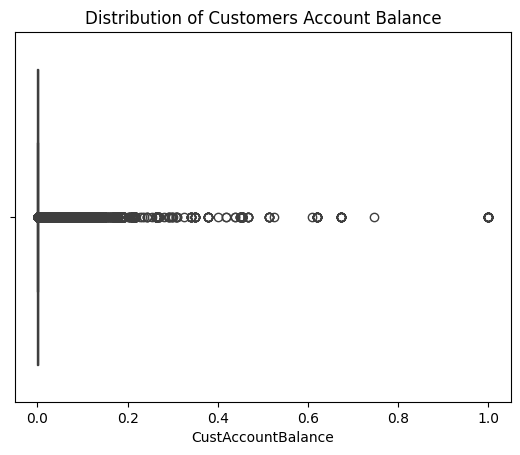

In [137]:
sns.boxplot(final_df, x='CustAccountBalance')
plt.title('Distribution of Customers Account Balance')
plt.show()

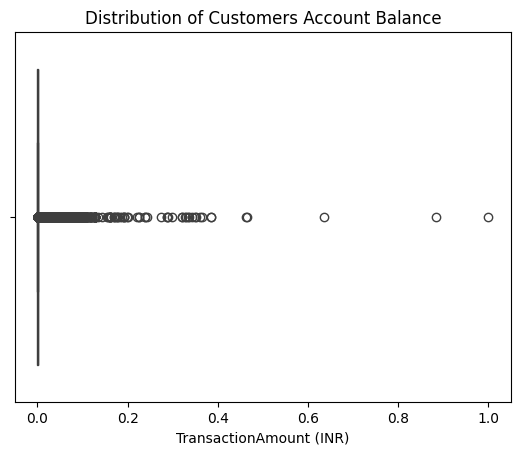

In [138]:
sns.boxplot(final_df, x='TransactionAmount (INR)')
plt.title('Distribution of Customers Account Balance')
plt.show()

In [ ]:
plt.pie()